# Overview

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-1c company.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tqdm

from collections import defaultdict
from matplotlib import rcParams
from typing import List
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import DecomposeResult

import data
import stats

# Load Data

In [2]:
train_df, test_df = data.load_data()
train_df = data.add_features(
    train_df,
    {
        "is_new_item": True,
        "is_first_shop_transaction": True
    }
)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date                       object 
 1   date_block_num             int64  
 2   shop_id                    int64  
 3   item_id                    int64  
 4   item_price                 float64
 5   item_cnt_day               float64
 6   item_name                  object 
 7   item_category_id           int64  
 8   item_category_name         object 
 9   shop_name                  object 
 10  city_name                  object 
 11  city_id                    int64  
 12  city_coord_1               float64
 13  city_coord_2               float64
 14  country_part               int64  
 15  is_new_item                int8   
 16  is_first_shop_transaction  int8   
dtypes: float64(4), int64(6), int8(2), object(5)
memory usage: 364.0+ MB


In [4]:
city_names_df = train_df.groupby(["city_id", "city_name"], as_index=False).count()[["city_id", "city_name"]]
city_names = dict()
for i, row in city_names_df.iterrows():
    city_names[row["city_id"]] = row["city_name"]

In [5]:
city_names

{0: 'адыгея',
 1: 'балашиха',
 2: 'волжский',
 3: 'вологда',
 4: 'воронеж',
 5: 'выездная',
 6: 'жуковский',
 7: 'интернет-магазин',
 8: 'казань',
 9: 'калуга',
 10: 'коломна',
 11: 'красноярск',
 12: 'курск',
 13: 'москва',
 14: 'мытищи',
 15: 'н.новгород',
 16: 'новосибирск',
 17: 'омск',
 18: 'ростовнадону',
 19: 'самара',
 20: 'сергиев',
 21: 'спб',
 22: 'сургут',
 23: 'томск',
 24: 'тюмень',
 25: 'уфа',
 26: 'химки',
 27: 'цифровой',
 28: 'чехов',
 29: 'якутск',
 30: 'ярославль'}

In [6]:
train_df.shape

(2935849, 17)

In [7]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,0,1
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,1,1
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,1,1
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0


In [8]:
print(f"Starting date: {train_df['date'].min()}")
print(f"Ending date: {train_df['date'].max()}")
print(f"Number of months: {len(train_df['date_block_num'].unique())}")

Starting date: 01.01.2013
Ending date: 31.12.2014
Number of months: 34


November 2015 & December 2015 are missing.

In [9]:
print(f"Number of shops: {len(train_df['shop_id'].unique())}")
print(f"Number of items: {len(train_df['item_id'].unique())}")
print(f"Number of categories: {len(train_df['item_category_id'].unique())}")

Number of shops: 60
Number of items: 21807
Number of categories: 84


In [10]:
train_df[["item_price","item_cnt_day"]].describe() 

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


In [11]:
print("Are there any missing values?")
train_df.isna().sum()

Are there any missing values?


date                         0
date_block_num               0
shop_id                      0
item_id                      0
item_price                   0
item_cnt_day                 0
item_name                    0
item_category_id             0
item_category_name           0
shop_name                    0
city_name                    0
city_id                      0
city_coord_1                 0
city_coord_2                 0
country_part                 0
is_new_item                  0
is_first_shop_transaction    0
dtype: int64

We can see that the data is already cleaned.

In [12]:
test_df.shape

(214200, 8)

In [13]:
test_df.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",NaN
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",NaN
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",NaN


In [14]:
print(f"Number of shops: {len(test_df['shop_id'].unique())}")
print(f"Number of items: {len(test_df['item_id'].unique())}")
print(f"Number of categories: {len(test_df['item_category_id'].unique())}")

Number of shops: 42
Number of items: 5100
Number of categories: 62


In [15]:
print("Are there any missing values?")
test_df.isna().sum()

Are there any missing values?


ID                         0
shop_id                    0
item_id                    0
item_name                  0
item_category_id           0
item_category_name         0
shop_name                  0
item_cnt_month        214200
dtype: int64

# Is Any Item Sold Twice in a Single Day?

In [16]:
df = train_df.groupby(["date", "shop_id", "item_id"]).count()["item_cnt_day"]
df[df > 1]

date        shop_id  item_id
01.05.2014  50       3423       2
02.03.2013  16       12133      2
05.01.2013  54       20130      2
06.04.2013  54       14050      2
07.03.2013  50       12133      2
07.10.2015  12       21619      2
09.03.2014  31       12133      2
12.02.2015  42       21619      2
12.07.2014  25       3423       2
14.08.2014  31       9842       2
16.02.2013  25       12133      2
16.08.2014  56       16587      2
17.02.2015  5        21619      2
18.02.2013  16       15702      2
21.02.2015  25       16587      2
21.11.2014  31       16587      2
22.12.2014  31       8237       2
23.02.2014  50       3423       2
23.03.2014  21       3423       2
25.01.2013  31       14050      2
26.12.2014  17       3424       2
27.01.2013  38       15702      2
28.12.2013  54       12133      2
29.01.2013  25       12133      2
29.12.2013  27       12133      2
30.03.2014  31       16875      2
31.12.2014  42       21619      2
            57       8237       2
Name: item_cnt_day,

In [17]:
# TODO
query_datetime = pd.to_datetime("2013-01-05", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 54 and item_id == 20130")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


In [18]:
df = df.query(f"shop_id == 54 and item_id == 20130")
print(f"This specific item was sold only {len(df)} times")
df.sort_values(by=["date"])

This specific item was sold only 0 times


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


In [19]:
query_datetime = pd.to_datetime("2013-01-29", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 25 and item_id == 12133")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


In [20]:
df = train_df.query(f"shop_id == 25 and item_id == 12133")
print(f"This specific item was sold {len(df)} times")
date_range = pd.date_range(start="2013-01-25", periods=100)
df = df[df["date"].isin(date_range)]
df.sort_values(by=["date"])

This specific item was sold 27 times


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


We can see that the price keeps varying between 1389 & 889.

In [21]:
query_datetime = pd.to_datetime("2015-02-12", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 42 and item_id == 21619")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


In [22]:
df = train_df.query(f"shop_id == 42 and item_id == 21619")
print(f"This specific item was sold {len(df)} times")
date_range = pd.date_range(start="2015-02-12", periods=100)
df = df[df["date"].isin(date_range)]
df.sort_values(by=["date"])

This specific item was sold 26 times


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


We can see again that the price is fluctuating.

In [23]:
query_datetime = pd.to_datetime("2015-10-07", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 12 and item_id == 21619")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


In [24]:
df = train_df.query(f"shop_id == 12 and item_id == 21619")
print(f"This specific item was sold {len(df)} times")
date_range = pd.date_range(start="2014-01-01", periods=10000)
df = df[df["date"].isin(date_range)]
df.sort_values(by=["date"])

This specific item was sold 5 times


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,is_new_item,is_first_shop_transaction


It seems that some `items have multiple transactions` in the same shop and date, but with a different `item_price`.

# Outliers

In [93]:
# TODO
def detect_outliers(df: pd.DataFrame):
    df = df.copy()
    
    axes = None
    _, axes = plt.subplots(2,3, figsize=(10,5), constrained_layout=True)
    axes[0, 0].set_title("Before Removing Outliers (Prices)")
    axes[1, 0].set_title("Before Removing Outliers (Sales)")
    sns.boxplot(x=df["item_price"], ax=axes[0, 0])
    sns.boxplot(x=df["item_cnt_day"], ax=axes[1, 0])
    
    df_hard_coded = df[(df["item_price"] > 0) & (df["item_price"] < 10000) & (df["item_cnt_day"] > 0) & (df["item_cnt_day"] < 1000)]
    axes[0, 1].set_title("Removed Outliers - Hard Coded (Prices)")
    axes[1, 1].set_title("After Removing Outliers - Hard Coded (Sales)")
    sns.boxplot(x=df_hard_coded["item_price"], ax=axes[0, 1])
    sns.boxplot(x=df_hard_coded["item_cnt_day"], ax=axes[1, 1])
    
    df_iqr = data.remove_outliers_iqr(df, columns=["item_price", "item_cnt_day"])
    axes[0, 2].set_title("After Removing Outliers - Iqr (Prices)")
    axes[1, 2].set_title("After Removing Outliers - Iqr (Sales)")
    sns.boxplot(x=df_iqr["item_price"], ax=axes[0, 2])
    sns.boxplot(x=df_iqr["item_cnt_day"], ax=axes[1, 2])
    plt.show()

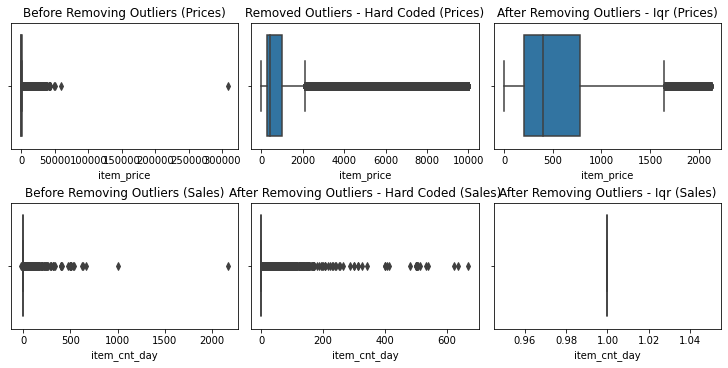

In [94]:
detect_outliers(train_df)

# Preprocess

## Detect Same Shops

In [27]:
def get_shop_name(df: pd.DataFrame, shop_id: int) -> str:
    row = df[df["shop_id"] == shop_id].iloc[0]
    
    return row["shop_name"]

In [28]:
print(get_shop_name(train_df, shop_id=0))
print(get_shop_name(train_df, shop_id=57))

!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56


In [29]:
print(get_shop_name(train_df, shop_id=1))
print(get_shop_name(train_df, shop_id=58))

!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"


In [30]:
print(get_shop_name(train_df, shop_id=10))
print(get_shop_name(train_df, shop_id=11))

Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²


In [31]:
print(get_shop_name(train_df, shop_id=40))
print(get_shop_name(train_df, shop_id=39))

РостовНаДону ТРК "Мегацентр Горизонт" Островной
РостовНаДону ТРК "Мегацентр Горизонт"


### Replace shop_id

In [32]:
train_df["shop_id"] = train_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
test_df["shop_id"] = test_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

Let's see how many unique shops we have now:

In [33]:
print(f"Number of shops in train_split: {len(train_df['shop_id'].unique())} (before = 60)")
print(f"Number of shops in test_split: {len(test_df['shop_id'].unique())} (before = 42)")

Number of shops in train_split: 56 (before = 60)
Number of shops in test_split: 42 (before = 42)


We can observe that those shops were not even present in the test split.

## Add Revenue Features

In [34]:
train_df["item_revenue"] = train_df["item_cnt_day"] * train_df["item_price"]

## Aggregate Data into Months

In [35]:
train_monthly_df_group = train_df.groupby(["date_block_num", "city_id", "shop_id", "item_category_id", "item_id"], as_index=False)
train_monthly_df = train_monthly_df_group.agg({"item_price": ["mean"], "item_cnt_day": ["sum", "mean", "count"], "item_revenue": ["sum"]})

In [36]:
train_monthly_df.head()

date_block_num city_id shop_id item_category_id item_id   item_price  \
                                                                  mean   
0              0       0       2                2    5572  1532.857143   
1              0       0       2                2    5573   924.000000   
2              0       0       2                2    5575   955.005000   
3              0       0       2                2    5576  2490.000000   
4              0       0       2                2    5632  2390.000000   

  item_cnt_day                 item_revenue  
           sum      mean count          sum  
0          9.0  1.285714     7     13910.00  
1          2.0  1.000000     2      1848.00  
2          4.0  1.000000     4      3820.02  
3          3.0  1.000000     3      7470.00  
4          1.0  1.000000     1      2390.00

In [37]:
train_monthly_df.columns = ["month_block", "city_id", "shop_id", "item_category_id", "item_id", "mean_item_price", "item_cnt", "mean_item_cnt_day", "transactions", "item_revenue"]
train_monthly_df.head()

,month_block,city_id,shop_id,item_category_id,item_id,mean_item_price,item_cnt,mean_item_cnt_day,transactions,item_revenue
0,0,0,2,2,5572,1532.857143,9.0,1.285714,7,13910.00
1,0,0,2,2,5573,924.000000,2.0,1.000000,2,1848.00
2,0,0,2,2,5575,955.005000,4.0,1.000000,4,3820.02
3,0,0,2,2,5576,2490.000000,3.0,1.000000,3,7470.00
4,0,0,2,2,5632,2390.000000,1.0,1.000000,1,2390.00


## Make Data Continuous

In [38]:
def fill_empty_months(df: pd.DataFrame) -> pd.DataFrame:
    month_ids = df["month_block"].unique()
    shop_ids = df["shop_id"].unique()
    item_ids = df["item_id"].unique()
    
    month_ids.sort()
    shop_ids.sort()
    item_ids.sort()
    
    # TODO: Speed up this for loops.
    empty_df = []
    for i in month_ids:
        for shop in shop_ids:
            for item in item_ids:
                empty_df.append([i, shop, item])
    empty_df = pd.DataFrame(empty_df, columns=["month_block","shop_id","item_id"])
    df = empty_df.merge(df, on=["month_block","shop_id","item_id"], how="left")
    df = df.fillna(0)
    
    return df

In [39]:
# TAKES TOO MUCH TIME.
# print(f"Number of records before making it continuous: {len(train_monthly_df)}")
# train_monthly_df = fill_empty_months(train_monthly_df)
# print(f"Number of records after making it continuous: {len(train_monthly_df)}")

## Add Time Features

In [40]:
train_monthly_df["year"] = train_monthly_df["month_block"].apply(lambda x: ((x//12) + 2013))
train_monthly_df["month"] = train_monthly_df["month_block"].apply(lambda x: (x % 12))

# EDA

# Company Level

## Sales for the Whole Company

Text(0, 0.5, 'Total Revenue')

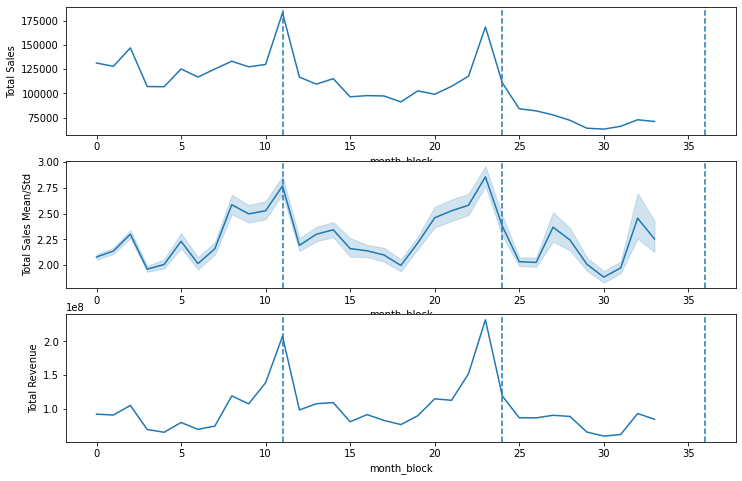

In [41]:
train_monthly_company_sales_df = train_monthly_df.groupby(["month_block"]).agg({"item_cnt": "sum", "item_revenue": "sum"})

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].axvline(11, 0, 3, linestyle="--")
ax[0].axvline(24, 0, 3, linestyle="--")
ax[0].axvline(36, 0, 3, linestyle="--")
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_df, ax=ax[1])
ax[1].axvline(11, 0, 3, linestyle="--")
ax[1].axvline(24, 0, 3, linestyle="--")
ax[1].axvline(36, 0, 3, linestyle="--")
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month_block", y="item_revenue", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].axvline(11, 0, 3, linestyle="--")
ax[2].axvline(24, 0, 3, linestyle="--")
ax[2].axvline(36, 0, 3, linestyle="--")
ax[2].set_ylabel("Total Revenue")

## Sales for the Whole Company (Overlaid)

Text(0, 0.5, 'Total Revenue')

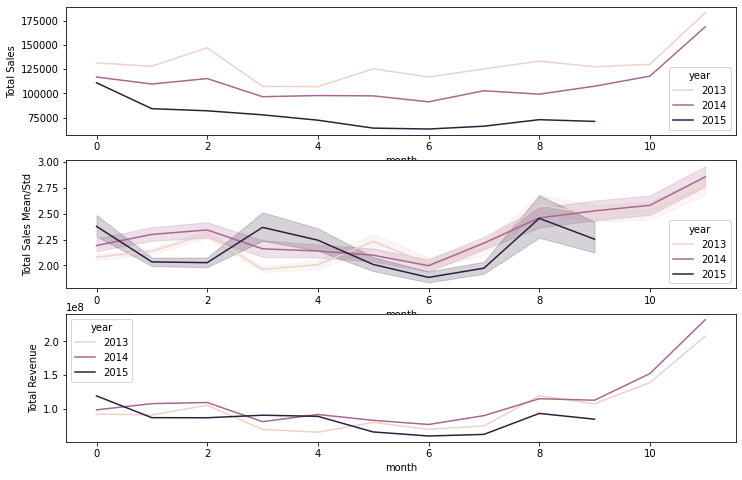

In [42]:
train_monthly_company_sales_df = train_monthly_df.groupby(["year", "month"]).agg({"item_cnt": "sum", "item_revenue": "sum"})
train_monthly_company_sales_df.head()

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_df, ax=ax[1])
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month", y="item_revenue", hue="year", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].set_ylabel("Total Revenue")

## Item Prices 

Text(0, 0.5, 'Total Item Prices Median')

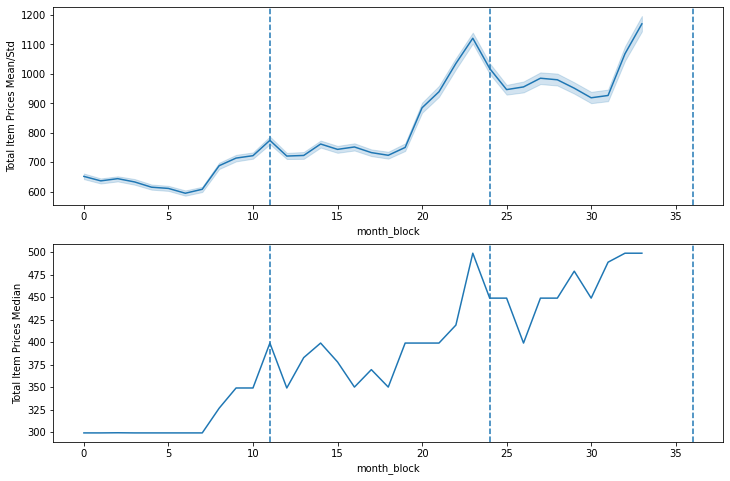

In [43]:
train_median_item_prices = train_monthly_df.groupby(["month_block"], as_index=False).agg({"mean_item_price": ["median"]})
train_median_item_prices.columns = ["month_block", "median_item_price"]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(x="month_block", y="mean_item_price", data=train_monthly_df, ax=ax[0])
ax[0].axvline(11, 0, 3, linestyle="--")
ax[0].axvline(24, 0, 3, linestyle="--")
ax[0].axvline(36, 0, 3, linestyle="--")
ax[0].set_ylabel("Total Item Prices Mean/Std")

sns.lineplot(x="month_block", y="median_item_price", data=train_median_item_prices, ax=ax[1])
ax[1].axvline(11, 0, 3, linestyle="--")
ax[1].axvline(24, 0, 3, linestyle="--")
ax[1].axvline(36, 0, 3, linestyle="--")
ax[1].set_ylabel("Total Item Prices Median")

## Item Sales vs Item Prices

In [44]:
def compare_cheaper_vs_expensive_items(df: pd.DataFrame):
    df = df.query("item_price < 100000 and item_cnt_day < 1000")
    sns.scatterplot(x=df["item_cnt_day"], y=df["item_price"], color="b")

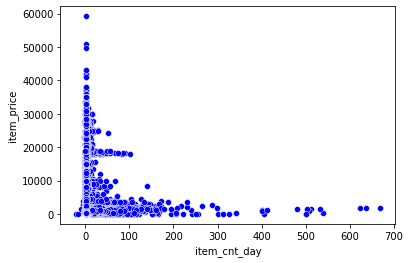

In [45]:
# TODO
compare_cheaper_vs_expensive_items(train_df)

## Distribution in Time of New Items

In [46]:
# TODO
new_items_df = train_df.groupby("date_block_num", as_index=False).agg({"is_new_item": ["sum"]})
new_items_df.columns = ["date_block_num", "is_new_item"]
new_items_df.head()

,date_block_num,is_new_item
0,0,3043.0
1,1,2557.0
2,2,1689.0
3,3,949.0
4,4,1331.0


<AxesSubplot:xlabel='date_block_num', ylabel='is_new_item'>

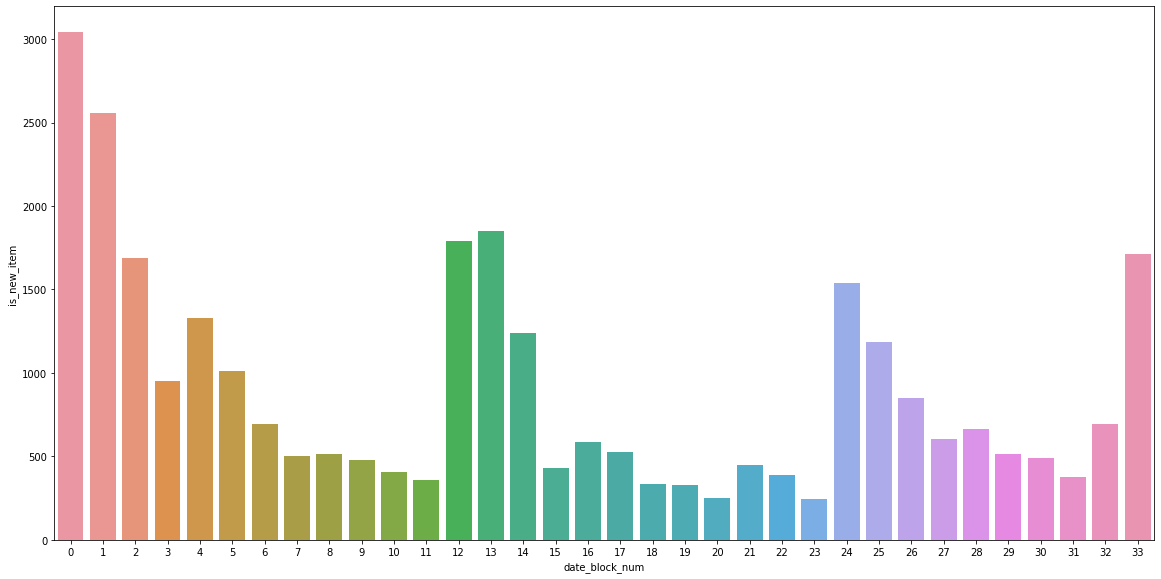

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
fig.tight_layout()
sns.barplot(x=new_items_df["date_block_num"], y=new_items_df["is_new_item"])

# Category Level

## What Category Sales More ?

In [48]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "item_cnt"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [49]:
train_categories_sales_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_cnt": ["sum"]})
train_categories_sales_df.columns = ["year", "item_category_id", "item_cnt"]

categories_year_2013 = train_categories_sales_df[train_categories_sales_df["year"] == 2013]
categories_year_2014 = train_categories_sales_df[train_categories_sales_df["year"] == 2014]
categories_year_2015 = train_categories_sales_df[train_categories_sales_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 330990.0)]

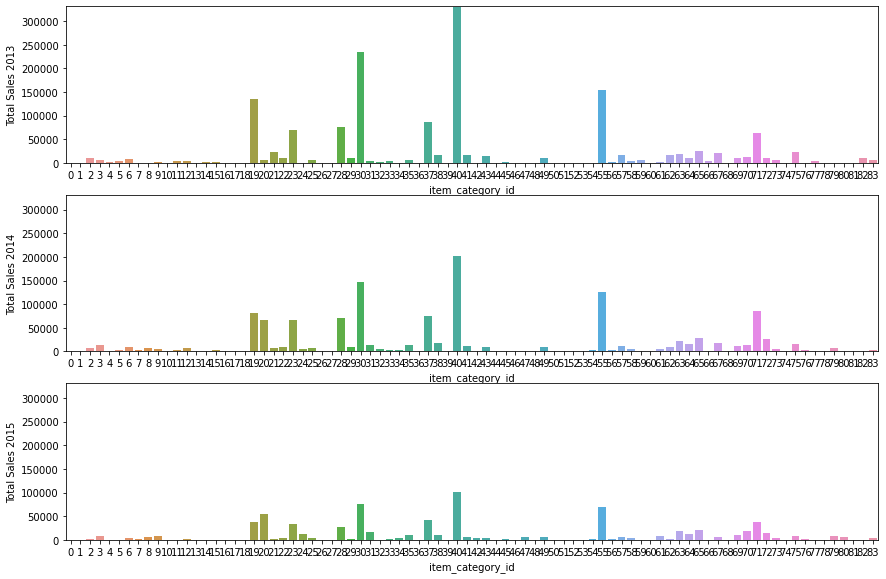

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))

## Number of Items / Category

In [51]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [52]:
train_number_items_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_id": ["count"]})
train_number_items_df.columns = ["year", "item_category_id", "num_items"]

categories_year_2013 = train_number_items_df[train_number_items_df["year"] == 2013]
categories_year_2014 = train_number_items_df[train_number_items_df["year"] == 2014]
categories_year_2015 = train_number_items_df[train_number_items_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 170699.0)]

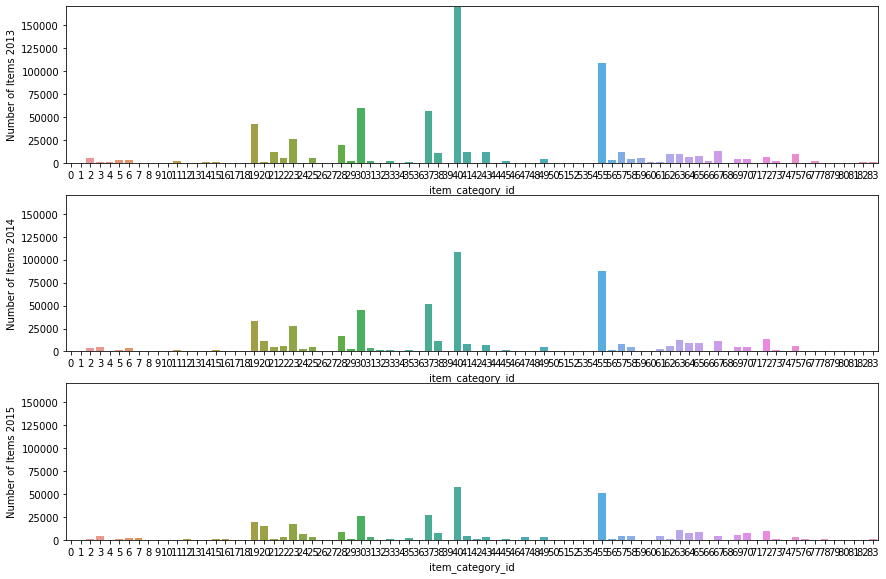

In [53]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="num_items", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Number of Items 2013")
ax[0].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Number of Items 2014")
ax[1].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Number of Items 2015")
ax[2].set(ylim=(0, train_number_items_df["num_items"].max() + 100))

# City Level

In [54]:
for city_id in sorted(list(city_names.keys())):
    print(f"{city_id} -> {city_names[city_id]}")

0 -> адыгея
1 -> балашиха
2 -> волжский
3 -> вологда
4 -> воронеж
5 -> выездная
6 -> жуковский
7 -> интернет-магазин
8 -> казань
9 -> калуга
10 -> коломна
11 -> красноярск
12 -> курск
13 -> москва
14 -> мытищи
15 -> н.новгород
16 -> новосибирск
17 -> омск
18 -> ростовнадону
19 -> самара
20 -> сергиев
21 -> спб
22 -> сургут
23 -> томск
24 -> тюмень
25 -> уфа
26 -> химки
27 -> цифровой
28 -> чехов
29 -> якутск
30 -> ярославль


## What City Sells more?

In [55]:
def fill_missing_cities(df: pd.DataFrame, all_possible_cities: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_cities = set(df["city_id"].unique())
    missing_cities = all_possible_cities - df_cities
    new_rows = []
    for missing_city_id in missing_cities:
        new_rows.append(
            (year, missing_city_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "city_id", "item_cnt"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [56]:
train_city_sales_df = train_monthly_df.groupby(["year", "city_id"], as_index=False).agg({"item_cnt": ["sum"]})
train_city_sales_df.columns = ["year", "city_id", "item_cnt"]

city_year_2013 = train_city_sales_df[train_city_sales_df["year"] == 2013]
city_year_2014 = train_city_sales_df[train_city_sales_df["year"] == 2014]
city_year_2015 = train_city_sales_df[train_city_sales_df["year"] == 2015]

all_possible_cities = set(city_year_2013["city_id"].unique()).union(set(city_year_2014["city_id"].unique())).union(set(city_year_2015["city_id"].unique()))
city_year_2013 = fill_missing_cities(city_year_2013, all_possible_cities)
city_year_2014 = fill_missing_cities(city_year_2014, all_possible_cities)
city_year_2015 = fill_missing_cities(city_year_2015, all_possible_cities)

[(0.0, 560440.0)]

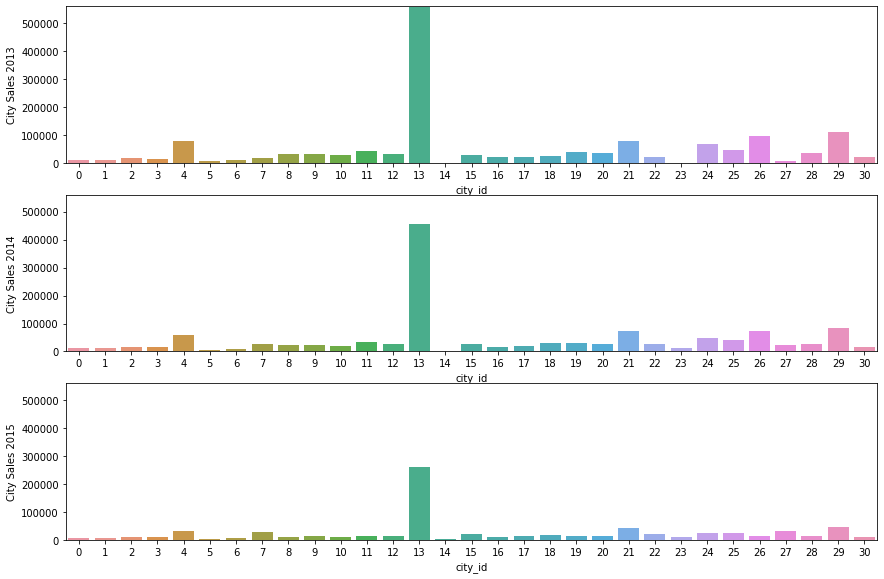

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="city_id", y="item_cnt", data=city_year_2013, ax=ax[0])
ax[0].set_ylabel("City Sales 2013")
ax[0].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))
sns.barplot(x="city_id", y="item_cnt", data=city_year_2014, ax=ax[1])
ax[1].set_ylabel("City Sales 2014")
ax[1].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))
sns.barplot(x="city_id", y="item_cnt", data=city_year_2015, ax=ax[2])
ax[2].set_ylabel("City Sales 2015")
ax[2].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))

## Number of Shops / City

<AxesSubplot:xlabel='city_id', ylabel='num_shops'>

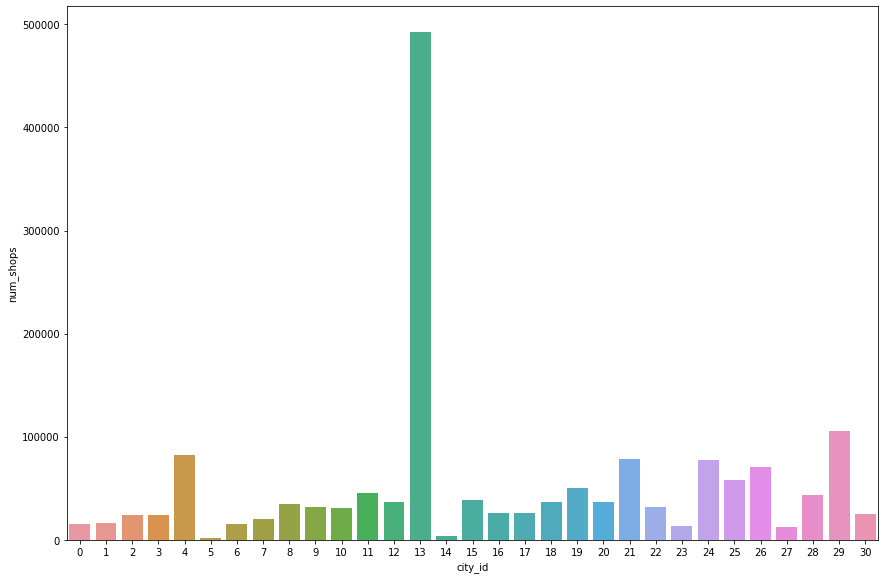

In [58]:
# TODO
shops_city_df = train_monthly_df.groupby(["city_id"], as_index=False).agg({"shop_id": "count"})
shops_city_df.columns = ["city_id", "num_shops"]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.tight_layout()
sns.barplot(x="city_id", y="num_shops", data=shops_city_df)

## Number of Items / City

In [59]:
def fill_missing_cities(df: pd.DataFrame, all_possible_cities: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_cities = set(df["city_id"].unique())
    missing_cities = all_possible_cities - df_cities
    new_rows = []
    for missing_city_id in missing_cities:
        new_rows.append(
            (year, missing_city_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "city_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [60]:
train_city_sales_df = train_monthly_df.groupby(["year", "city_id"], as_index=False).agg({"item_id": ["count"]})
train_city_sales_df.columns = ["year", "city_id", "num_items"]

city_year_2013 = train_city_sales_df[train_city_sales_df["year"] == 2013]
city_year_2014 = train_city_sales_df[train_city_sales_df["year"] == 2014]
city_year_2015 = train_city_sales_df[train_city_sales_df["year"] == 2015]

all_possible_cities = set(city_year_2013["city_id"].unique()).union(set(city_year_2014["city_id"].unique())).union(set(city_year_2015["city_id"].unique()))
city_year_2013 = fill_missing_cities(city_year_2013, all_possible_cities)
city_year_2014 = fill_missing_cities(city_year_2014, all_possible_cities)
city_year_2015 = fill_missing_cities(city_year_2015, all_possible_cities)

[(0.0, 218417.0)]

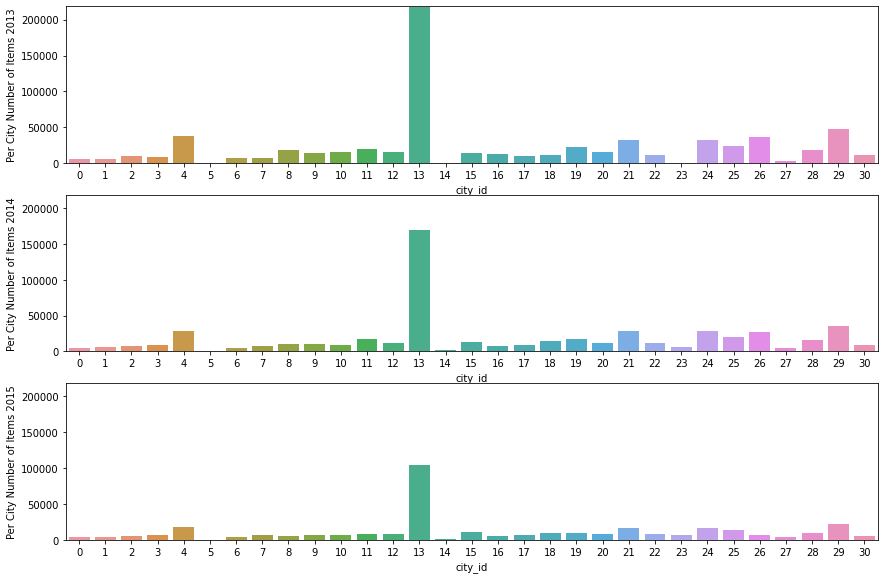

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="city_id", y="num_items", data=city_year_2013, ax=ax[0])
ax[0].set_ylabel("Per City Number of Items 2013")
ax[0].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))
sns.barplot(x="city_id", y="num_items", data=city_year_2014, ax=ax[1])
ax[1].set_ylabel("Per City Number of Items 2014")
ax[1].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))
sns.barplot(x="city_id", y="num_items", data=city_year_2015, ax=ax[2])
ax[2].set_ylabel("Per City Number of Items 2015")
ax[2].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))

# Shop Level 

In [62]:
city_shop_groups = train_monthly_df.groupby(["city_id", "shop_id"])
flattened_shops = defaultdict(list)
for name, group in city_shop_groups:
    city_name = city_names[group['city_id'].iloc[0]]
    flattened_shops[city_name].append(group['shop_id'].iloc[0])
print(f"{'city_name':<16} -- [shop_ids]")
for city_name, shop_ids in flattened_shops.items():
    print(f"{city_name:<16} -- {shop_ids}")

city_name        -- [shop_ids]
адыгея           -- [2]
балашиха         -- [3]
волжский         -- [4]
вологда          -- [5]
воронеж          -- [6, 7, 8]
выездная         -- [9]
жуковский        -- [10]
интернет-магазин -- [12]
казань           -- [13, 14]
калуга           -- [15]
коломна          -- [16]
красноярск       -- [17, 18]
курск            -- [19]
москва           -- [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
мытищи           -- [33]
н.новгород       -- [34, 35]
новосибирск      -- [36, 37]
омск             -- [38]
ростовнадону     -- [39, 41]
самара           -- [44, 45]
сергиев          -- [46]
спб              -- [42, 43]
сургут           -- [47]
томск            -- [48]
тюмень           -- [49, 50, 51]
уфа              -- [52, 53]
химки            -- [54]
цифровой         -- [55]
чехов            -- [56]
якутск           -- [57, 58]
ярославль        -- [59]


## What Shop Sells More?

In [63]:
def fill_missing_shops(df: pd.DataFrame, all_shop_ids: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_shop_ids = set(df["shop_id"].unique())
    missing_shop_ids = all_shop_ids - df_shop_ids
    new_rows = []
    for missing_shop_id in missing_shop_ids:
        new_rows.append(
            (year, missing_shop_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "shop_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [64]:
train_shop_sales_df = train_monthly_df.groupby(["year", "shop_id"], as_index=False).agg({"item_cnt": ["sum"], "item_revenue": ["sum"]})
train_shop_sales_df.columns = ["year", "shop_id", "item_cnt", "item_revenue"]

shops_year_2013 = train_shop_sales_df[train_shop_sales_df["year"] == 2013]
shops_year_2014 = train_shop_sales_df[train_shop_sales_df["year"] == 2014]
shops_year_2015 = train_shop_sales_df[train_shop_sales_df["year"] == 2015]

all_possible_shop_ids = set(shops_year_2013["shop_id"].unique()).union(set(shops_year_2014["shop_id"].unique())).union(set(shops_year_2015["shop_id"].unique()))
shops_year_2013 = fill_missing_shops(shops_year_2013, all_possible_shop_ids)
shops_year_2014 = fill_missing_shops(shops_year_2014, all_possible_shop_ids)
shops_year_2015 = fill_missing_shops(shops_year_2015, all_possible_shop_ids)

[(0.0, 132587.0)]

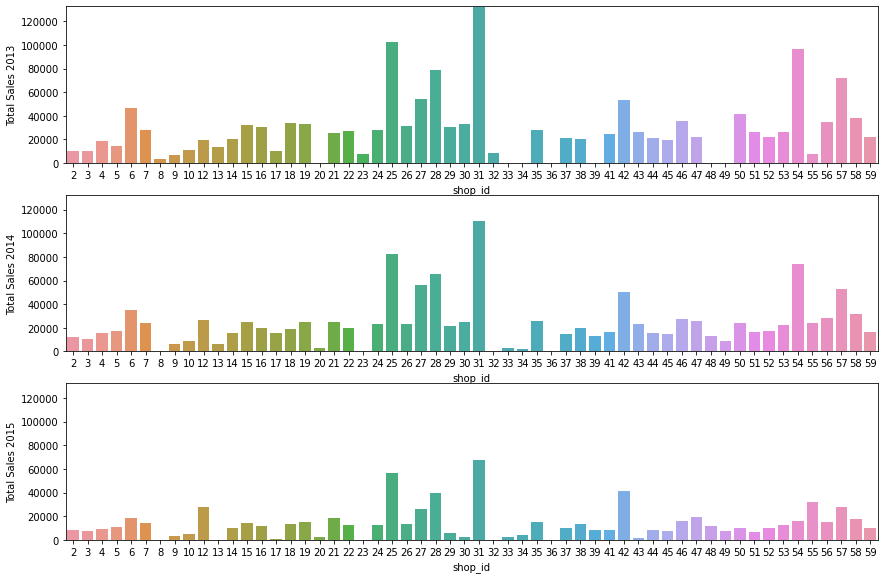

In [65]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))

## Number of Items / Shop

In [66]:
def fill_missing_shops(df: pd.DataFrame, all_shop_ids: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_shop_ids = set(df["shop_id"].unique())
    missing_shop_ids = all_shop_ids - df_shop_ids
    new_rows = []
    for missing_shop_id in missing_shop_ids:
        new_rows.append(
            (year, missing_shop_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "shop_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [67]:
train_shop_sales_df = train_monthly_df.groupby(["year", "shop_id"], as_index=False).agg({"item_cnt": ["count"]})
train_shop_sales_df.columns = ["year", "shop_id", "num_items"]

shops_year_2013 = train_shop_sales_df[train_shop_sales_df["year"] == 2013]
shops_year_2014 = train_shop_sales_df[train_shop_sales_df["year"] == 2014]
shops_year_2015 = train_shop_sales_df[train_shop_sales_df["year"] == 2015]

all_possible_shop_ids = set(shops_year_2013["shop_id"].unique()).union(set(shops_year_2014["shop_id"].unique())).union(set(shops_year_2015["shop_id"].unique()))
shops_year_2013 = fill_missing_shops(shops_year_2013, all_possible_shop_ids)
shops_year_2014 = fill_missing_shops(shops_year_2014, all_possible_shop_ids)
shops_year_2015 = fill_missing_shops(shops_year_2015, all_possible_shop_ids)

[(0.0, 41129.0)]

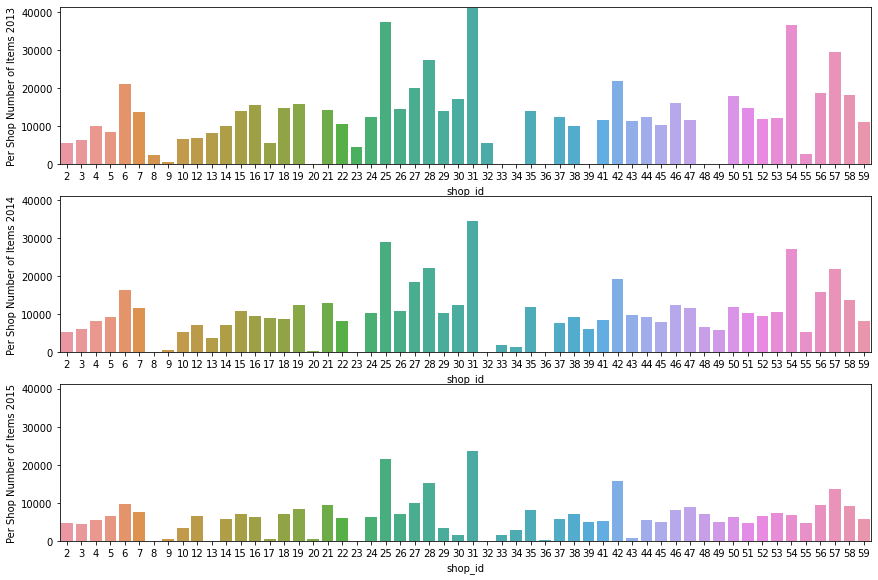

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="shop_id", y="num_items", data=shops_year_2013, ax=ax[0])
ax[0].set_ylabel("Per Shop Number of Items 2013")
ax[0].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))
sns.barplot(x="shop_id", y="num_items", data=shops_year_2014, ax=ax[1])
ax[1].set_ylabel("Per Shop Number of Items 2014")
ax[1].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))
sns.barplot(x="shop_id", y="num_items", data=shops_year_2015, ax=ax[2])
ax[2].set_ylabel("Per Shop Number of Items 2015")
ax[2].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))

## Prices Distribution for a Store

In [69]:
def plot_prices_distribution_store(df: pd.DataFrame, shop_id: int):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id}")
    
    fig, axes = plt.subplots(1, 1, figsize=(14, 8))
    sns.histplot(x=df["item_price"])

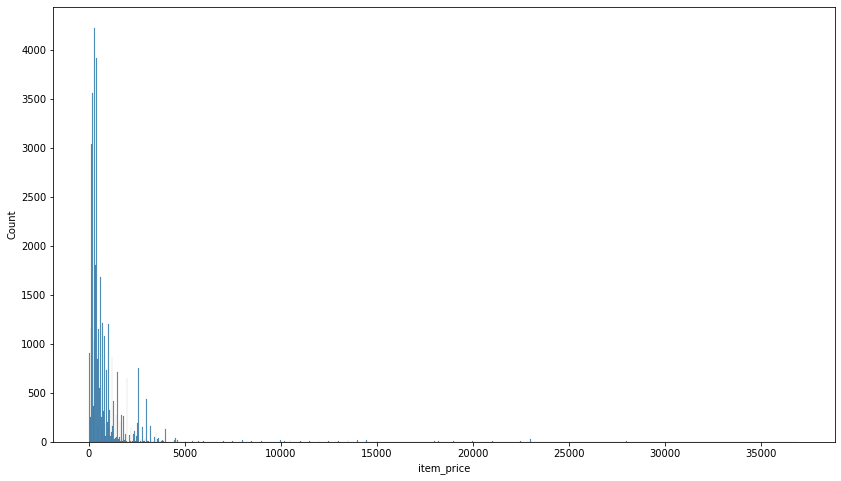

In [70]:
plot_prices_distribution_store(train_df, shop_id=5)

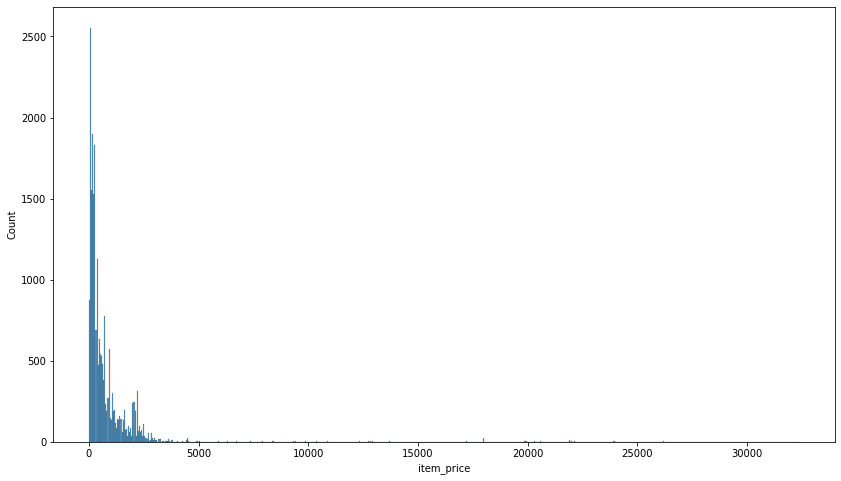

In [71]:
plot_prices_distribution_store(train_df, shop_id=10)

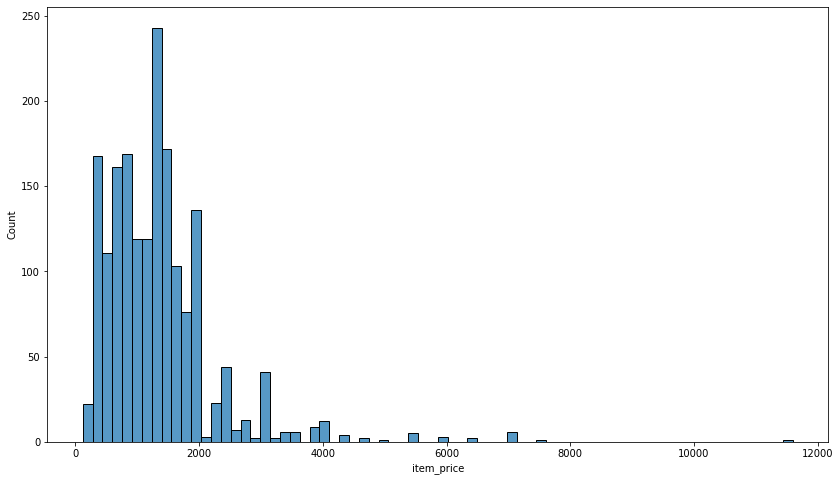

In [72]:
plot_prices_distribution_store(train_df, shop_id=20)

## Same Item Different Stores

In [73]:
def plot_item_for_different_stores(df: pd.DataFrame, item_id: int):
    df = df.copy()
    df = df.query(f"item_id == {item_id}")
    df = df.groupby(["date", "shop_id", "item_id"], as_index=False).agg({"item_price": ["mean"]})
    df.columns = ["date", "shop_id", "item_id", "item_price"]
    
    fig = sns.lineplot(x=df["date"], y=df["item_price"], hue=df["shop_id"])
    plt.tight_layout() 

In [74]:
shop_counts_df = train_df.groupby("item_id").agg({"shop_id":["count"]})
shop_counts_df.columns = ["count"]
shop_counts_df[shop_counts_df["count"] >= 30000]

,count
item_id,
20949,31340


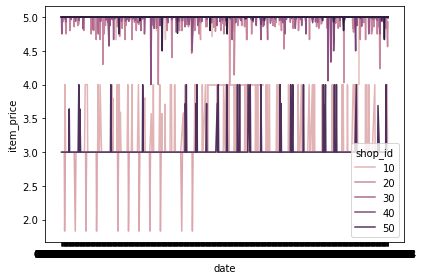

In [75]:
plot_item_for_different_stores(train_df, item_id=20949)

## Distribution in Time of New Items / Shop

In [76]:
# TODO
def plot_distribution_in_time(df: pd.DataFrame, shop_id: int):
    df = df.query(f"shop_id == {shop_id}")
    new_items_df = df.groupby("date_block_num", as_index=False).agg({"is_first_shop_transaction": ["sum"]})
    new_items_df.columns = ["date_block_num", "is_first_shop_transaction"]
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.tight_layout()
    sns.barplot(x="date_block_num", y="is_first_shop_transaction", data=new_items_df)

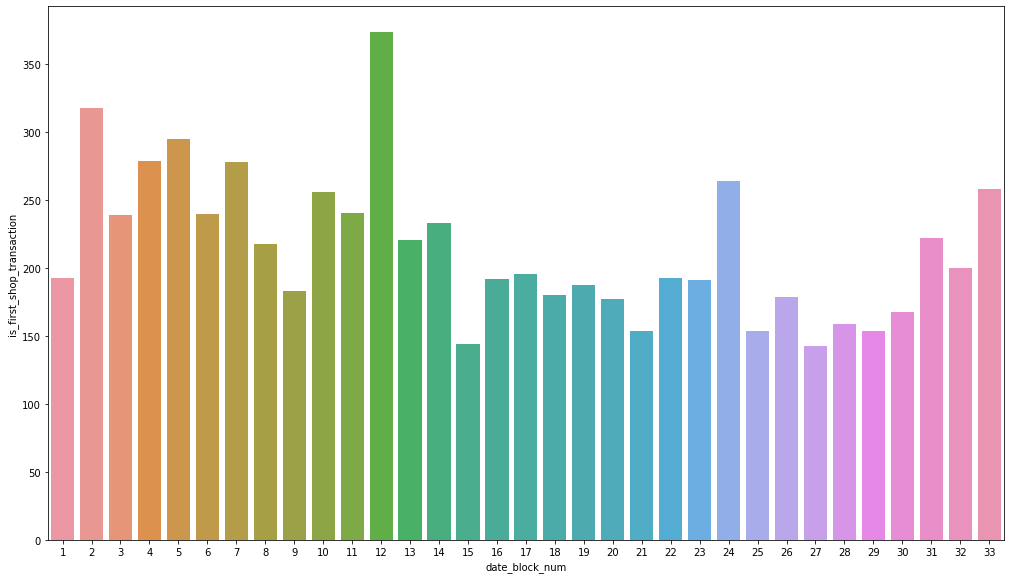

In [77]:
plot_distribution_in_time(train_df, shop_id=5)

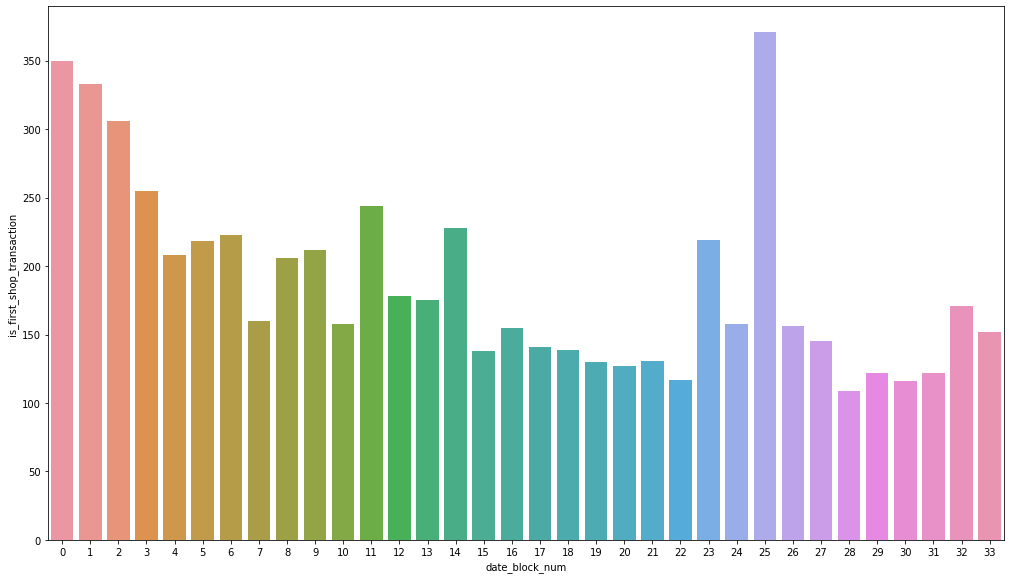

In [78]:
plot_distribution_in_time(train_df, shop_id=10)

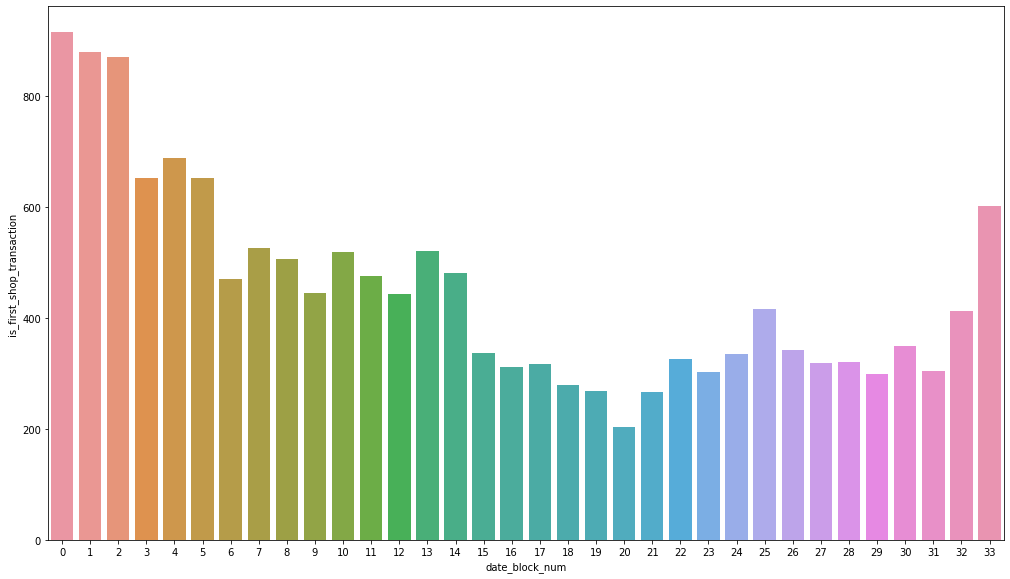

In [79]:
# Moscov citiy.
plot_distribution_in_time(train_df, shop_id=25)

## Decomposition

In [80]:
def decompose(df: pd.DataFrame, shop_id: int, plot_default: bool = False):
    """
        df: DataFrame with a daily frequency
    """
    
    all_months = df["month_block"]
    all_months =range(all_months.min(), all_months.max())
    df = df[df["shop_id"] == shop_id]
    df = df.groupby(["month_block"]).sum()
    
    # Reindex the time series so the 1D frequency is consistent.
    df = df.reindex(all_months)
    df = df.fillna(0)
    
    old_figsize = rcParams["figure.figsize"]
    rcParams["figure.figsize"] = 12, 10
    
    # TODO
    stl = STL(df["item_cnt"], robust=False, period=4, seasonal=7, seasonal_deg=1, trend_deg=1, low_pass_deg=1)
    res = stl.fit()
    fig = res.plot()
    if plot_default is True:
        second_stl = STL(df["item_cnt"], period=2)
        second_stl = second_stl.fit()
        add_stl_plot(fig, second_stl, legend=["Custom", "Default"])
    
    rcParams["figure.figsize"] = old_figsize
    

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

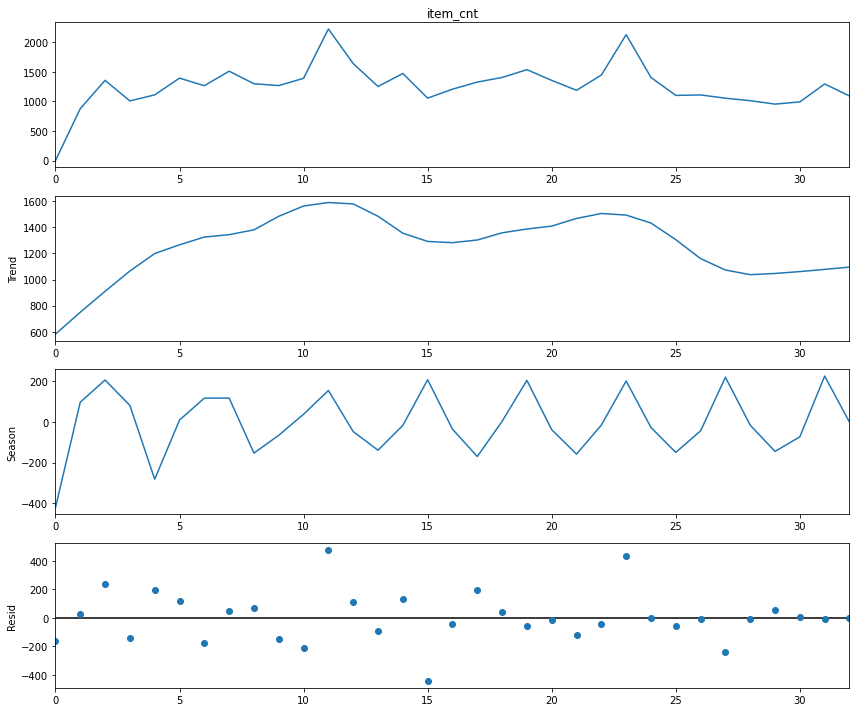

In [81]:
decompose(train_monthly_df, shop_id=5, plot_default=False)

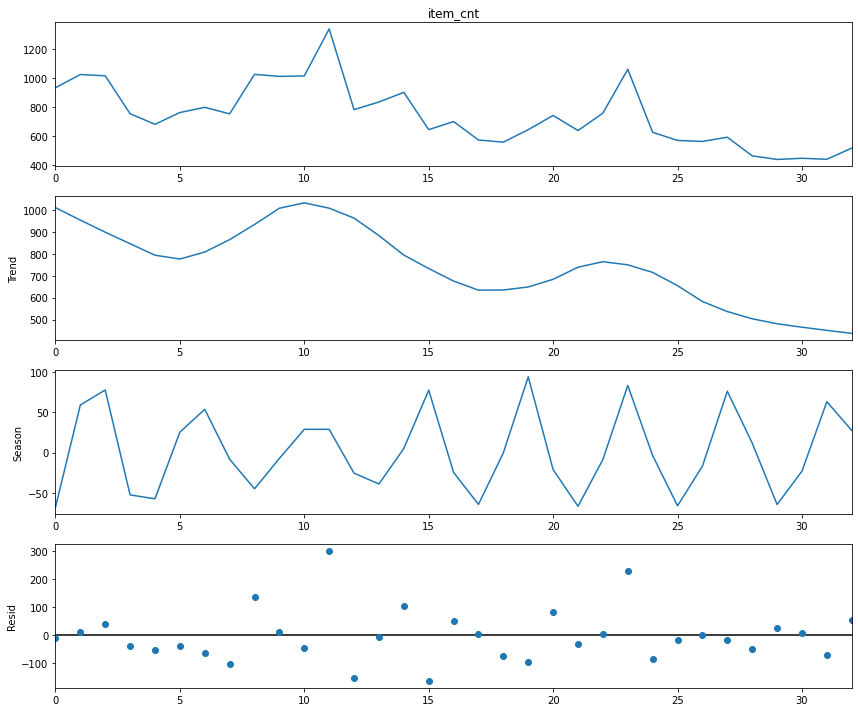

In [82]:
decompose(train_monthly_df, shop_id=10)

##  Correlation

In [83]:
def correlation_matrix(df: pd.DataFrame, columns: List[str], shop_id: int):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    matrix = df[columns].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()

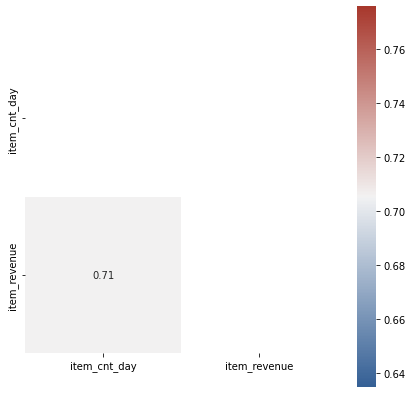

In [84]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=5)

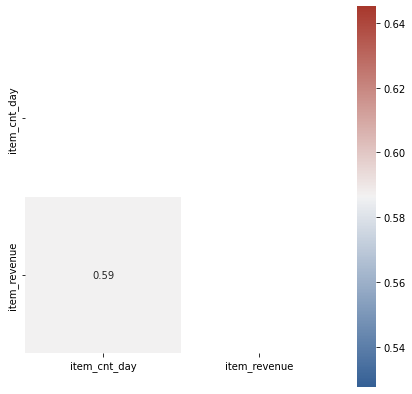

In [85]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=10)

## Autocorrelation

In [86]:
# TODO
def autocorrelation(df: pd.DataFrame, shop_id: int, month_lags: int = 18, print_from: int = 2):
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    
    assert len(df) > 0
    
    corr, sign = sm.tsa.stattools.acf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, missing="raise")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("Most important ACF lags that have statistical significance:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    sm.graphics.tsa.plot_acf(df["item_cnt_day"], lags=30*month_lags, ax=axes)
    axes.set_title(f"Daily Item Sales ACF for ~{month_lags} Months")
    
    month_lags = int(len(df) * 0.5 / 30) # Can only compute PACF for up to 50% of the length of the data.
    corr, sign = sm.tsa.stattools.pacf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, method="ywm")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("\nMost important PACF lags that have statistical significance:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    sm.graphics.tsa.plot_pacf(df["item_cnt_day"], lags=30*month_lags, ax=axes, method="ywm")
    axes.set_title(f"Daily Item Sales PACF for ~{month_lags} Months")

    
def correlation_plot(d, dt=6e-3, **kwargs):
    corr, conf = sm.tsa.stattools.acf(d, nlags=len(d)-1, alpha=0.05)
    taus = dt*np.arange(0, len(d))
    ax = plt.gca()
    ax.plot(taus, corr, **kwargs)
    ax.fill_between(taus, y1=conf[:,0] - corr, y2=conf[:,1] - corr, color='g', alpha=0.2, lw=0)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ (seconds)')
    ax.set_ylabel(r'$G(\tau)$')
    ax.grid()

Most important ACF lags that have statistical significance:
(32, 0.29882194375910565, array([0.22661698, 0.37102691]))
(33, 0.2237168563404778, array([0.14689007, 0.30054364]))
(231, 0.1853410825188237, array([0.08528532, 0.28539685]))
(199, 0.1690300734488982, array([0.07292326, 0.26513689]))
(31, 0.17505480415068414, array([0.10450571, 0.2456039 ]))
(462, 0.11328447656078841, array([0.00059713, 0.22597182]))
(263, 0.12215532530013287, array([0.01861477, 0.22569588]))
(430, 0.10957185615761823, array([-0.00134678,  0.22049049]))
(64, 0.13233783209820138, array([0.04800025, 0.21667542]))
(198, 0.11923106157059747, array([0.02369646, 0.21476566]))

Most important PACF lags that have statistical significance:
(32, 0.24471438276067858, array([0.18261055, 0.30681822]))
(31, 0.1472746364905325, array([0.0851708 , 0.20937847]))
(33, 0.14479959639946427, array([0.08269576, 0.20690343]))
(2, -0.1246595520520482, array([-0.18676339, -0.06255572]))
(30, 0.08905946687794042, array([0.02695563, 0.

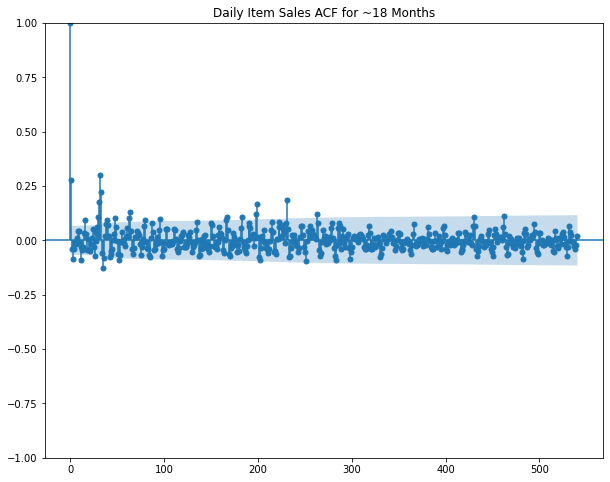

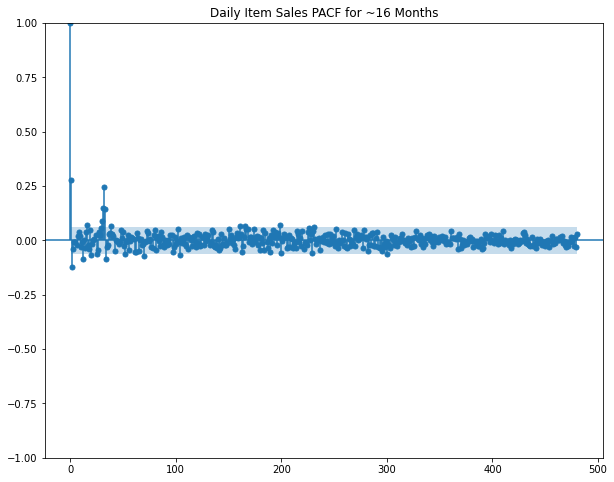

In [87]:
autocorrelation(train_df, shop_id=5)

Most important ACF lags that have statistical significance:
(34, 0.2845694915446398, array([0.21639242, 0.35274657]))
(68, 0.15904501920818875, array([0.08111906, 0.23697098]))
(65, 0.15653038122774046, array([0.08000917, 0.23305159]))
(336, 0.1237841494859608, array([0.01662648, 0.23094182]))
(102, 0.1446654027654803, array([0.06086496, 0.22846584]))
(237, 0.12983963337013643, array([0.03167137, 0.2280079 ]))
(271, 0.12572526346862256, array([0.02375304, 0.22769749]))
(370, 0.11791919926482247, array([0.00822836, 0.22761003]))
(31, 0.15299434177854715, array([0.08684644, 0.21914225]))
(71, 0.13937542573512524, array([0.05975581, 0.21899504]))

Most important PACF lags that have statistical significance:
(34, 0.2309038150872732, array([0.16980393, 0.2920037 ]))
(31, 0.13454175002292998, array([0.07344186, 0.19564164]))
(3, 0.12684671209609716, array([0.06574683, 0.1879466 ]))
(33, 0.12162186146732654, array([0.06052197, 0.18272175]))
(6, 0.09399731978555642, array([0.03289743, 0.155097

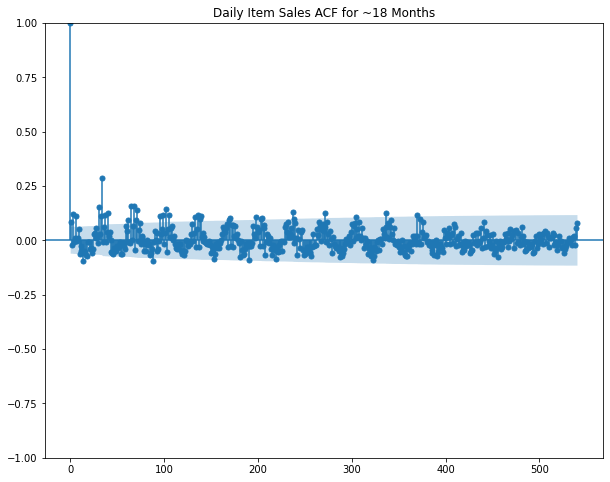

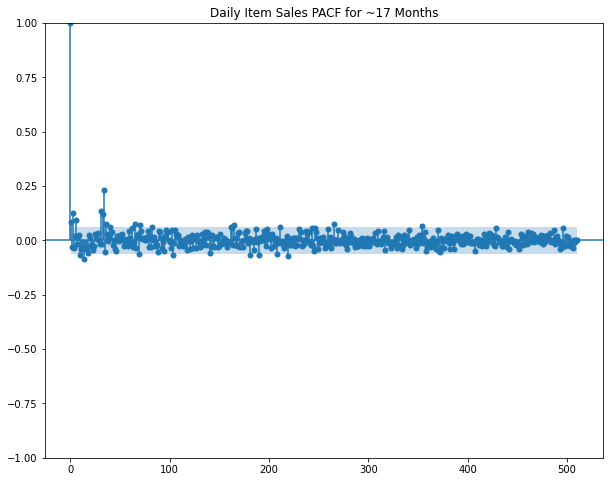

In [88]:
autocorrelation(train_df, shop_id=10)

## Aggregate Lag Autocorrelation

In [89]:
# TODO
def aggregate_lag_autocorrelation(df: pd.DataFrame):
    # num_days = df["date"].max() - df["date"].min()
    num_days = 600
    shop_ids = df["shop_id"].unique()
    
    shop_lags_acf = np.zeros(shape=(max(shop_ids) + 1, num_days))
    shop_lags_pacf = np.zeros(shape=(max(shop_ids) + 1, num_days))
    aggregated_lag_acf = np.zeros(shape=(num_days,))
    aggregated_lag_pacf = np.zeros(shape=(num_days,))
    for shop_id in tqdm.tqdm(shop_ids):
        shop_acf_values = stats.find_most_significant_acf_values(df, shop_id)
        for lag, corr in shop_acf_values:
            if lag < num_days:
                shop_lags_acf[shop_id, int(lag)] = corr
                aggregated_lag_acf[int(lag)] += 1
            
        shop_pacf_values = stats.find_most_significant_pacf_values(df, shop_id)
        for lag, corr in shop_pacf_values:
            if lag < num_days:
                if corr > 1:
                    corr = 1.
                elif corr < -1:
                    corr = -1
                shop_lags_pacf[shop_id, int(lag)] = corr
                aggregated_lag_pacf[int(lag)] += 1
        
    aggregated_lag_acf /= len(shop_ids)
    aggregated_lag_pacf /= len(shop_ids)
    
    fig, axes = plt.subplots(2,1,figsize=(20,3))
    x = np.linspace(0,num_days)
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    axes[0].imshow(aggregated_lag_acf[np.newaxis,:], cmap="Greys", aspect="auto", extent=extent)
    axes[0].set_ylabel("ACF")
    axes[0].set_xticks(np.arange(0, num_days, 50))
    axes[1].imshow(aggregated_lag_pacf[np.newaxis,:], cmap="Greys", aspect="auto", extent=extent)
    axes[1].set_ylabel("PACF")
    axes[1].set_xticks(np.arange(0, num_days, 50))
    
    fig, axes = plt.subplots(2,1,figsize=(30,30))
    sns.heatmap(shop_lags_acf, ax=axes[0])
    axes[0].set_ylabel("ACF")
    sns.heatmap(shop_lags_pacf, ax=axes[1])
    axes[1].set_ylabel("PACF")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [05:07<00:00,  5.49s/it]


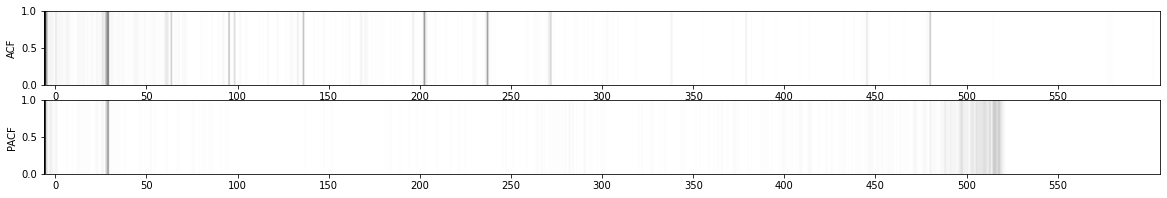

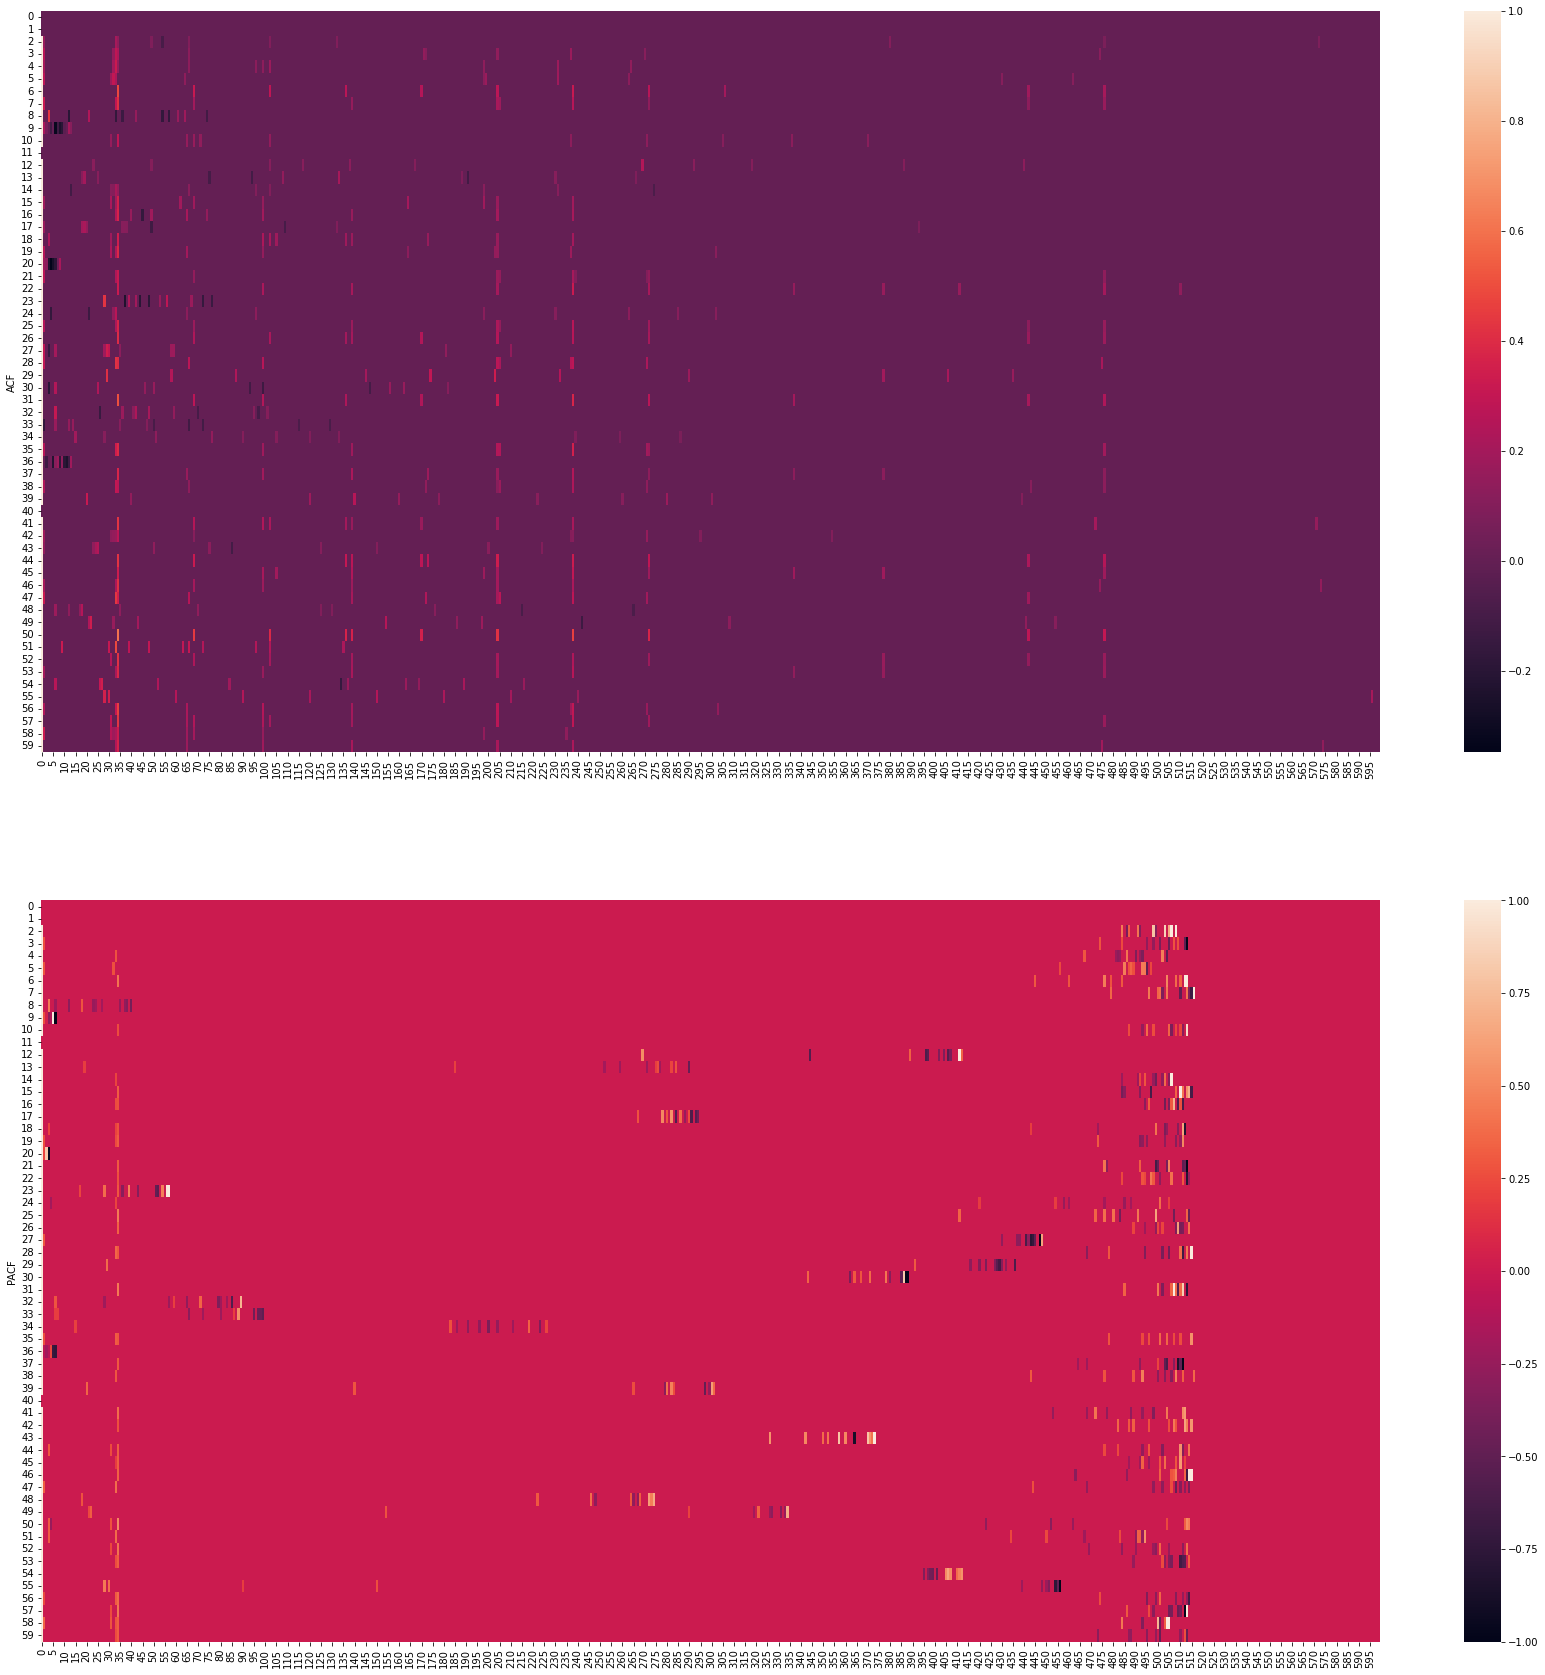

In [90]:
aggregate_lag_autocorrelation(train_df)

## Moving Averages

In [91]:
def plot_moving_averages(df: pd.DataFrame, shop_id: int):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id}")
    df = df.groupby("date", as_index=False).sum()
    print(f"Length original df = {len(df)}")
    
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="1D")
    df_empty = pd.DataFrame(index=date_range, columns=[])
    df_empty = df_empty.reset_index()
    df_empty.columns = ["date"]
    df = df_empty.merge(df, on=["date"], how="left")
    print(f"Length padded df = {len(df)}")
    
    nan_indexes = [index for index, row in df.iterrows() if row.isnull().any()]
    df["item_cnt_day_ema_14"] = df["item_cnt_day"].ewm(span=14, adjust=True, ignore_na=True).mean()
    df["item_cnt_day_ema_30"] = df["item_cnt_day"].ewm(span=30, adjust=True, ignore_na=True).mean()
    df["item_cnt_day_std_14"] = df["item_cnt_day"].ewm(span=14, adjust=True, ignore_na=True).std()
    df["item_cnt_day_std_30"] = df["item_cnt_day"].ewm(span=30, adjust=True, ignore_na=True).std()
    df["item_revenue_ema_14"] = df["item_revenue"].ewm(span=14, adjust=True, ignore_na=True).mean()
    df["item_revenue_ema_30"] = df["item_revenue"].ewm(span=30, adjust=True, ignore_na=True).mean()
    df["item_revenue_std_14"] = df["item_revenue"].ewm(span=14, adjust=True, ignore_na=True).std()
    df["item_revenue_std_30"] = df["item_revenue"].ewm(span=30, adjust=True, ignore_na=True).std()
    df.loc[nan_indexes] = np.nan
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    axes[0].plot(df.index, df["item_cnt_day"], label="Item Sales")
    axes[0].plot(df.index, df["item_cnt_day_ema_14"], label="Item Sales EMA 14")
    axes[0].plot(df.index, df["item_cnt_day_ema_30"], label="Item Sales EMA 30")
    axes[0].plot(df.index, df["item_cnt_day_std_14"], label="Item Sales STD 14")
    axes[0].plot(df.index, df["item_cnt_day_std_30"], label="Item Sales STD 30")
    axes[0].set_ylabel(f"Item Sales for Shop {shop_id}")
    axes[1].plot(df.index, df["item_revenue"], label="Item Revenue")
    axes[1].plot(df.index, df["item_revenue_ema_14"], label="Item Revenue EMA 14")
    axes[1].plot(df.index, df["item_revenue_ema_30"], label="Item Revenue EMA 30")
    axes[1].plot(df.index, df["item_revenue_std_14"], label="Item Revenue STD 14")
    axes[1].plot(df.index, df["item_revenue_std_30"], label="Item Revenue STD 30")
    axes[1].set_ylabel(f"Item Revenue for Shop {shop_id}")
    plt.legend()

In [92]:
plot_moving_averages(train_df, shop_id=5)

Length original df = 996


/tmp/ipykernel_19086/2247444573.py:1: UserWarning: Parsing '31.12.2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  plot_moving_averages(train_df, shop_id=5)


ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [ ]:
plot_moving_averages(train_df, shop_id=10)

In [ ]:
plot_moving_averages(train_df, shop_id=24)

# Item Level

## Item Sales & Transactions

In [ ]:
def plot_all_items_for_shop(df: pd.DataFrame, shop_id: int):
    df = df.query(f"shop_id == {shop_id}")
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    sns.lineplot(x=df["month_block"], y=df["item_cnt"], hue=df["item_id"], ax=axes[0])
    axes[0].set_ylabel("Sales")
    sns.lineplot(x=df["month_block"], y=df["transactions"], hue=df["item_id"], ax=axes[1])
    axes[1].set_ylabel("Transactions")

In [ ]:
plot_all_items_for_shop(train_monthly_df, shop_id=5)

In [ ]:
plot_all_items_for_shop(train_monthly_df, shop_id=10)

## Correlation Sales / Prices

In [ ]:
def item_correlation_matrix(df: pd.DataFrame, shop_id: int, item_id: int):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.groupby("date").mean()
    matrix = df[["item_cnt_day", "item_price"]].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()
    
    
def raw_correlation_matrix(df: pd.DataFrame):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    matrix = df[["item_cnt_day", "item_price"]].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()

### Filtered Item Correlation

In [ ]:
df = train_df.query("shop_id == 5").groupby("item_id", as_index=False).agg({"date": ["count"]})
df.columns = ["item_id", "count"]
df.max()

In [ ]:
df[df["count"] == 711]

In [ ]:
train_df.query("shop_id == 5 and item_id == 20949")

In [ ]:
item_correlation_matrix(train_df, shop_id=5, item_id=20949)

### Raw Correlation

In [ ]:
raw_correlation_matrix(train_df)

## Item Price

In [ ]:
def plot_item_price(df: pd.DataFrame, item_id: int):
    df = df.query(f"item_id == {item_id}")
    df = df.groupby(["date", "item_id"], as_index=False).agg({"item_price": ["mean"], "item_cnt_day": ["sum"]})
    df.columns = ["date", "item_id", "item_price", "item_cnt_day"]
    
    fig, axes = plt.subplots(2, 1, figsize=(14,8))
    fig.suptitle(f"Item {item_id} across all shops", fontsize=12)
    sns.lineplot(x=df["date"], y=df["item_price"], ax=axes[0])
    axes[0].set_ylabel(f"Item Price")
    sns.barplot(x=df["date"], y=df["item_cnt_day"], ax=axes[1])
    axes[1].set_ylabel(f"Item Sales")

In [ ]:
plot_item_price(train_df, 20949)

In [ ]:
plot_item_price(train_df, 1444)

In [ ]:
plot_item_price(train_df, 1555)

## Autocorrelation

In [ ]:
count_item_sales = train_df.groupby(["shop_id", "item_id"], as_index=False).agg({"item_cnt_day": ["count"]})
count_item_sales.columns = ["shop_id", "item_id", "num_transactions"]
count_item_sales = count_item_sales.query("shop_id == 5")
count_item_sales = count_item_sales.sort_values(by=["num_transactions"])
count_item_sales.tail()

In [ ]:
def item_autocorrelation(df: pd.DataFrame, shop_id: int, item_id: int, print_from: int = 1):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.groupby("date").sum()
    df = df.sort_index()
    
    assert len(df) > 0
    
    month_lags = len(df) // 30
    corr, sign = sm.tsa.stattools.acf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, missing="raise")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("\nMost important lags that have statistical significance for ACF:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    sm.graphics.tsa.plot_acf(df["item_cnt_day"], lags=30*month_lags, ax=axes)
    axes.set_title(f"Daily Item Sales ACF for ~{month_lags} Months")
    
    month_lags = int(len(df) * 0.50 / 30) # Can only compute PACF for up to 50% of the length of the data.
    corr, sign = sm.tsa.stattools.pacf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, method="ywm")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("\nMost important lags that have statistical significance for PACF:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    sm.graphics.tsa.plot_pacf(df["item_cnt_day"], lags=30*month_lags, ax=axes, method="ywm")
    axes.set_title(f"Daily Item Sales PACF for ~{month_lags} Months")
    plt.plot()

In [ ]:
item_autocorrelation(train_df, shop_id=5, item_id=20949)

In [ ]:
# TODO
item_autocorrelation(train_df, shop_id=5, item_id=17717)

In [ ]:
item_autocorrelation(train_df, shop_id=5, item_id=2308)

In [ ]:
item_autocorrelation(train_df, shop_id=5, item_id=17717)

## Decomposition

In [ ]:
def decompose(df: pd.DataFrame, shop_id: int, item_id: int):
    """
        df: DataFrame with a daily frequency
    """
    
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.query(f"item_cnt >= 0")
    
    all_months = df["month_block"]
    all_months =range(all_months.min(), all_months.max())
    df = df.groupby(["month_block"]).sum()
    # Reindex the time series so the 1D frequency is consistent.
    df = df.reindex(all_months)
    df = df.fillna(0)
    
    old_figsize = rcParams["figure.figsize"]
    rcParams["figure.figsize"] = 12, 10
    
    # TODO
    stl = STL(df["item_cnt"], robust=True, period=4, seasonal=7, seasonal_deg=1, trend_deg=1, low_pass_deg=1)
    res = stl.fit()
    fig = res.plot()
    
    rcParams["figure.figsize"] = old_figsize

In [ ]:
decompose(train_monthly_df, shop_id=5, item_id=20949)